# Discretization using pyAgrum's DiscreteTypeProcessor

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

Most of the functionality of pyAgrum works only on discrete data. However data in the real world can be often continous. This class can be used to create dizcretized variables from continous data. Since this class was made for the purposes of the class BNClassifier, this class accepts data in the form of ndarrays. To transform data from a csv file to an ndarray we can use the function in BNClassifier XYfromCSV. 

## Creation of an instance and setting parameters

To create an instance of this class we need to specify the default parameters (the discretization method and the number of bins) for discretizing data. We create a type_processor which uses the EWD (Equal Width Discretization) method with 5 bins. The threshold is used for determining if a variable is already discretized. In this case, if a variable has more than 10 unique values we treat it as continous. we can use the setDiscretizationParameters method to set the discretization parameters for a specific variable

In [1]:
%load_ext autoreload
%autoreload 2

import pyagrum.skbn as skbn
from pyagrum.lib.discreteTypeProcessor import DiscreteTypeProcessor

type_processor = DiscreteTypeProcessor(
  defaultDiscretizationMethod="uniform", defaultNumberOfBins=5, discretizationThreshold=10
)

## Auditing data

To see how certain data will be treated by the type_processor we can use the audit method.

In [2]:
import pandas

X = pandas.DataFrame.from_dict(
  {
    "var1": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3],
    "var2": ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n"],
    "var3": [1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2],
    "var4": [1.11, 2.213, 3.33, 4.23, 5.42, 6.6, 7.5, 8.9, 9.19, 10.11, 11.12, 12.21, 13.3, 14.5],
    "var5": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1],
  }
)

print(X)

auditDict = type_processor.audit(X)

print()
print("** audit **")
for var in auditDict:
  print(f"- {var} : ")
  for k, v in auditDict[var].items():
    print(f"    + {k} : {v}")

    var1 var2  var3    var4  var5
0      1    a     1   1.110     1
1      2    b     2   2.213     2
2      3    c     5   3.330     3
3      4    d     1   4.230     4
4      5    e     2   5.420     5
5      6    f     5   6.600     6
6      7    g     1   7.500     7
7      8    h     2   8.900     8
8      9    i     5   9.190     9
9     10    j     1  10.110    10
10    11    k     2  11.120    11
11     1    l     5  12.210    12
12     2    m     1  13.300    13
13     3    n     2  14.500     1

** audit **
- var1 : 
    + method : uniform
    + nbBins : 5
    + type : Continuous
    + minInData : 1
    + maxInData : 11
- var2 : 
    + method : NoDiscretization
    + values : ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n']
    + type : Discrete
- var3 : 
    + method : NoDiscretization
    + values : [1 2 5]
    + type : Discrete
- var4 : 
    + method : uniform
    + nbBins : 5
    + type : Continuous
    + minInData : 1.11
    + maxInData : 14.5
- var5 : 
    + me

We can see that even though var1 has more unique values than var1, it is treated as a discrete variable. This is because the values of var2 are strings and therefore cannot be discretized.

Now we would like to discretized var1 using k-means, var4 using decille and we would like for var3 to stay not discretized but with all the value from 1 to 5...

In [5]:
type_processor = DiscreteTypeProcessor(
  defaultDiscretizationMethod="uniform", defaultNumberOfBins=5, discretizationThreshold=10
)

type_processor.setDiscretizationParameters("var1", "kmeans")
type_processor.setDiscretizationParameters("var4", "quantile", 10)
type_processor.setDiscretizationParameters("var3", "NoDiscretization", "[1,5]") # same format for type as pyagrum.fastVar

auditDict = type_processor.audit(X)

print()
print("** audit **")
for var in auditDict:
  print(f"- {var} : ")
  for k, v in auditDict[var].items():
    print(f"    + {k} : {v}")


** audit **
- var1 : 
    + method : kmeans
    + param : 5
    + type : Continuous
    + minInData : 1
    + maxInData : 11
- var2 : 
    + method : NoDiscretization
    + values : ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n']
    + type : Discrete
- var3 : 
    + method : NoDiscretization
    + param : [1,5]
    + type : Discrete
- var4 : 
    + method : quantile
    + param : 10
    + type : Continuous
    + minInData : 1.11
    + maxInData : 14.5
- var5 : 
    + method : uniform
    + nbBins : 5
    + type : Continuous
    + minInData : 1
    + maxInData : 13


## Creating template BN from data

To create a template BN (and the variables) from data we can use the createVariable method for each column in our data matrix. This will use the parameters that we have already set to create discrete (or discretized) variables from our data.

In [6]:
template_bn = type_processor.discretizedTemplate(X)

print(template_bn)
print(template_bn["var1"])
print(template_bn["var2"])
print(template_bn["var3"])
print(template_bn["var4"])
print(template_bn["var5"])

BN{nodes: 5, arcs: 0, domainSize: 17500, dim: 34, mem: 312o}
var1:Discretized(<(1;2.625[,[2.625;5.125[,[5.125;7.5[,[7.5;9.5[,[9.5;11)>)
var2:Labelized({a|b|c|d|e|f|g|h|i|j|k|l|m|n})
var3:Range([1,5])
var4:Discretized(<(1.11;2.5481[,[2.5481;3.87[,[3.87;5.301[,[5.301;6.78[,[6.78;8.2[,[8.2;9.132[,[9.132;10.211[,[10.211;11.556[,[11.556;12.973[,[12.973;14.5)>)
var5:Discretized(<(1;3.4[,[3.4;5.8[,[5.8;8.2[,[8.2;10.6[,[10.6;13)>)


For supervised discretization algorithms (MDLP and CAIM) the list of class labels for each datapoint is also needed.


In [7]:
y = [True, False, False, True, False, False, True, True, False, False, True, True, False, True]

type_processor.setDiscretizationParameters("var4", "CAIM")
template_bn = type_processor.discretizedTemplate(X, y)
print(template_bn["var4"])
type_processor.setDiscretizationParameters("var4", "MDLP")
template_bn = type_processor.discretizedTemplate(X, y)
print(template_bn["var4"])

var4:Discretized(<(1.11;10.615[,[10.615;14.5)>)
var4:Discretized(<(1.11;1.6615[,[1.6615;14.5)>)


The type_processor keeps track of the number of discretized variables created by it and the number of bins used to discretize them. To reset these two numbers to 0 we can use the clear method. We can also use it to clear the specific parameteres we have set for each variable.

In [8]:
print(f"numberOfContinuous : {type_processor.numberOfContinuous}")
print(f"totalNumberOfBins : {type_processor.totalNumberOfBins}")

type_processor.clear()
print("\n")

print(f"numberOfContinuous : {type_processor.numberOfContinuous}")
print(f"totalNumberOfBins : {type_processor.totalNumberOfBins}")

type_processor.audit(X)

numberOfContinuous : 9
totalNumberOfBins : 44


numberOfContinuous : 0
totalNumberOfBins : 0


{'var1': {'method': 'kmeans',
  'param': 5,
  'type': 'Continuous',
  'minInData': 1,
  'maxInData': 11},
 'var2': {'method': 'NoDiscretization', 'type': 'Discrete'},
 'var3': {'method': 'NoDiscretization', 'param': '[1,5]', 'type': 'Discrete'},
 'var4': {'method': 'MDLP',
  'param': 5,
  'type': 'Continuous',
  'minInData': 1.11,
  'maxInData': 14.5},
 'var5': {'method': 'uniform',
  'nbBins': 5,
  'type': 'Continuous',
  'minInData': 1,
  'maxInData': 13}}

In [9]:
type_processor.clear(True)
type_processor.audit(X)

{'var1': {'method': 'uniform',
  'nbBins': 5,
  'type': 'Continuous',
  'minInData': 1,
  'maxInData': 11},
 'var2': {'method': 'NoDiscretization',
  'values': array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
         'n'], dtype=object),
  'type': 'Discrete'},
 'var3': {'method': 'NoDiscretization',
  'values': array([1, 2, 5], dtype=object),
  'type': 'Discrete'},
 'var4': {'method': 'uniform',
  'nbBins': 5,
  'type': 'Continuous',
  'minInData': 1.11,
  'maxInData': 14.5},
 'var5': {'method': 'uniform',
  'nbBins': 5,
  'type': 'Continuous',
  'minInData': 1,
  'maxInData': 13}}

## Using DiscreteTypeProcessor with BNClassifier

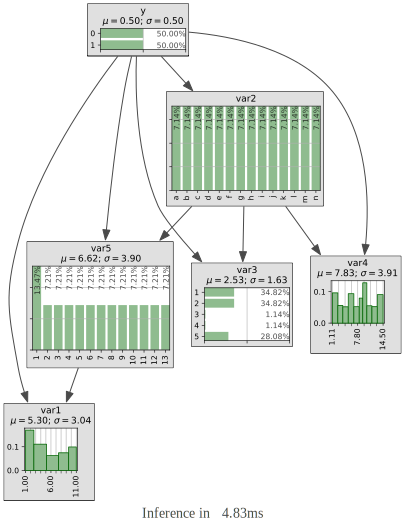

In [11]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb

import pandas as pd

X = pandas.DataFrame.from_dict(
  {
    "var1": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3],
    "var2": ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n"],
    "var3": [1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2],
    "var4": [1.11, 2.213, 3.33, 4.23, 5.42, 6.6, 7.5, 8.9, 9.19, 10.11, 11.12, 12.21, 13.3, 14.5],
    "var5": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1],
  }
)
Y = [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]

classif = skbn.BNClassifier(learningMethod="TAN")
# by default number of bins is 5
classif.type_processor.setDiscretizationParameters("var1", "kmeans")
# ... but 10 for var4
classif.type_processor.setDiscretizationParameters("var4", "quantile", 10)
# in the database, var3 only takes values 1,2 or 5 but 3 and 4 are also possible
classif.type_processor.setDiscretizationParameters("var3", "NoDiscretization", "[1, 5]")

classif.fit(X, Y)

gnb.showInference(classif.bn)

## Using Discretizer with BNLearner

In [12]:
import pyagrum.lib.notebook as gnb

import pyagrum.skbn as skbn

file_name = "res/discretizable.csv"
data = pd.read_csv(file_name)

type_processor = DiscreteTypeProcessor(
  defaultDiscretizationMethod="quantile", defaultNumberOfBins=10, discretizationThreshold=25
)

In [13]:
# creating a template explaining the variables proposed by the type_processor. This variables will be used by the learner
template = type_processor.discretizedTemplate(data)

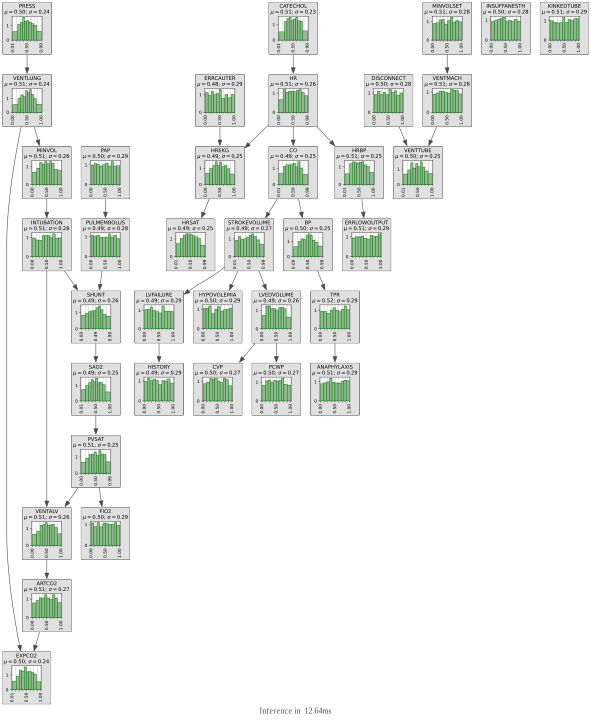

In [14]:
learner = gum.BNLearner(file_name, template)
learner.useMIIC()
learner.useNMLCorrection()

bn = learner.learnBN()
gnb.showInference(bn, size="10!")

## Comparing discretization methods

Different discretization for the same mixture of 2 Gaussians.

In [15]:
import numpy as np
import pandas

N = 20000
N1 = 2 * N // 3
N2 = N - N1

classY = np.array([1] * N1 + [0] * N2)
data = pandas.DataFrame(
  data={
    "y": classY,
    # discretiation using quantile (15 bins)
    "q15": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
    # discretiation using uniform (15 bins)
    "u15": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
    # discretiation using kmeans (15 bins)
    "k15": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
    # discretiation using quantile (5 bins)
    "q5": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
    # discretiation using kmeans (5 bins)
    "k5": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
    # other discretization methods
    "caim": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
    "mdlp": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
    "expert": np.concatenate((np.random.normal(0, 2, N1), np.random.normal(10, 2, N2))),
  }
)

type_processor = DiscreteTypeProcessor(
  defaultDiscretizationMethod="quantile", defaultNumberOfBins=15, discretizationThreshold=10
)

type_processor.setDiscretizationParameters("u15", method="uniform")
type_processor.setDiscretizationParameters("k15", method="kmeans")
type_processor.setDiscretizationParameters("q5", method="quantile", parameters=5)
type_processor.setDiscretizationParameters("k5", method="kmeans", parameters=5)
type_processor.setDiscretizationParameters("caim", method="CAIM", parameters=5)
type_processor.setDiscretizationParameters("mdlp", method="MDLP", parameters=5)
type_processor.setDiscretizationParameters("expert", method="expert", parameters=[-30.0, -2, 0.2, 1, 30.0])

By default, the distributions for discretized variables are represented as "histogram"(the surface of the bars are proportionnal to the probabilities).

In [16]:
template = type_processor.discretizedTemplate(data, y=classY, possibleValuesY=[0, 1])
for i, n in template:
  print(f"{n:7} : {template.variable(i)}")

y       : y:Range([0,1])
q15     : q15:Discretized(<(-7.85525;-2.57876[,[-2.57876;-1.70549[,[-1.70549;-1.08133[,[-1.08133;-0.529052[,[-0.529052;-0.0241644[,[-0.0241644;0.49082[,[0.49082;1.04935[,[1.04935;1.70816[,[1.70816;2.55946[,[2.55946;5.09752[,[5.09752;8.2862[,[8.2862;9.5124[,[9.5124;10.5492[,[10.5492;11.6934[,[11.6934;18.3898)>)
u15     : u15:Discretized(<(-7.44286;-5.62191[,[-5.62191;-3.80096[,[-3.80096;-1.98001[,[-1.98001;-0.159054[,[-0.159054;1.6619[,[1.6619;3.48285[,[3.48285;5.3038[,[5.3038;7.12475[,[7.12475;8.9457[,[8.9457;10.7667[,[10.7667;12.5876[,[12.5876;14.4086[,[14.4086;16.2295[,[16.2295;18.0505[,[18.0505;19.8714)>)
k15     : k15:Discretized(<(-7.66171;-4.04464[,[-4.04464;-2.62875[,[-2.62875;-1.52562[,[-1.52562;-0.506443[,[-0.506443;0.515826[,[0.515826;1.5961[,[1.5961;2.87799[,[2.87799;4.88564[,[4.88564;7.05232[,[7.05232;8.58557[,[8.58557;9.81766[,[9.81766;10.9436[,[10.9436;12.118[,[12.118;13.5271[,[13.5271;16.9147)>)
q5      : q5:Discretized(<(-8.0494;-1.011[,[-1.011;

In [17]:
learner = gum.BNLearner(data, template)
bn = gum.BayesNet(template)
for i, n in bn:
  if n != "y":
    bn.addArc("y", n)
bn

(pyagrum.BayesNet@0x10519f600) BN{nodes: 9, arcs: 8, domainSize: 10^6.97543, dim: 121, mem: 1Ko 80o}

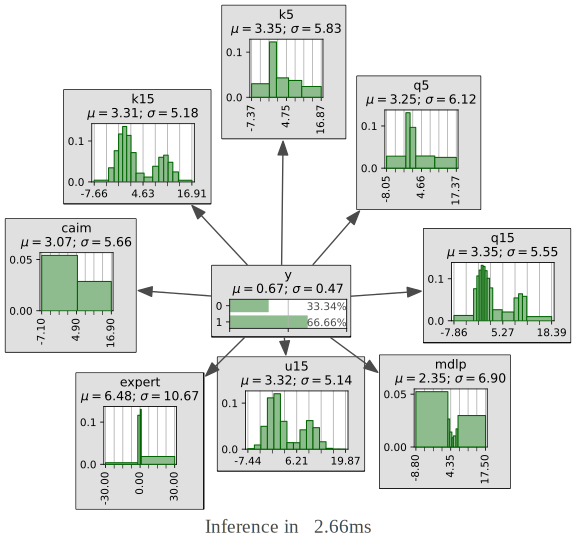

In [18]:
# learner.useMIIC()
# bn=learner.learnBN()
learner.fitParameters(bn)

# dot | neato | fdp | sfdp | twopi | circo | osage | patchwork
gum.config.push()
gum.config["notebook", "graph_layout"] = "fdp"
gnb.showInference(bn, size="8!")
gum.config.pop()

But you can always choose to show them as as "bar" (the height of the bars are proportionnal to the probabilities) instead of "histogram" (the area of the bars is proportionnal to the probabilites)

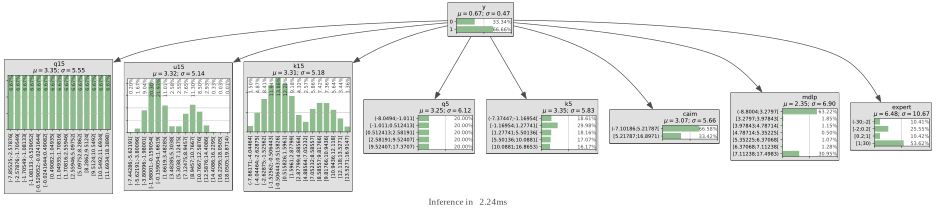

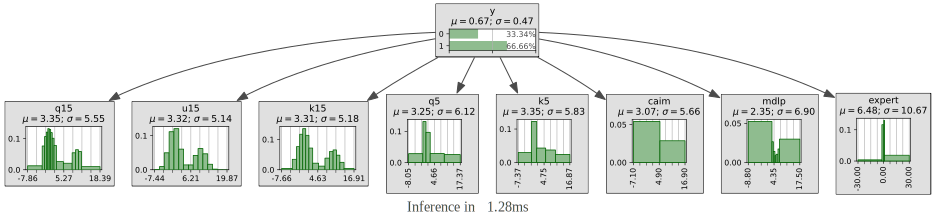

In [19]:
# changing how discretized variable are visualized
gum.config.push()
gum.config["notebook", "histogram_discretized_visualisation"] = "bar"
gnb.showInference(bn, size="13!")
gum.config.pop()  # default (above) is "histogram"
gnb.showInference(bn, size="13!")